In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import tqdm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

In [3]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

### 1. Базовый разведочный анализ данных

In [4]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_store = pd.read_csv("store.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_train['Date'] = df_train['Date'].astype('datetime64[ns]')
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Набор данных train содержит следующую информацию:
- Store - id магазина;
- DayOfWeek - день недели;
- Date - дата;
- Sales - количество проданных товаров (оборот магазина в рассматриваемый день. Это величина, которую надо предсказать);
- Customers - количество покупателей в рассматриваемый день;
- Open - индикатор того, был ли магазин открыт (0 - закрыт; 1 - открыт);
- Promo - индикатор того, была ли в магазине промо-акция (?) в рассматриваемый день;
- StateHoliday - индикатор того, был ли в этот день выходной. Возможные значения: a - обычный выходной; b - Пасха; с - Рождество; 0 - не выходной день;
- SchoolHoliday - указывает, были ли закрыты школы в этот день (?)

In [6]:
df_test['Date'] = df_test['Date'].astype('datetime64[ns]')
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


Тут всё тоже замое, но количество продаж неизвестно

In [7]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Дополнительные характеристики магазинов:
- StoreType - 4 различных возможных модели магазина: a, b, c, d;
- Assortment - описывает уровень ассортимента: a - основной, b - дополнительный; c - расширенный;
- CompetitionDistance - расстояние в метрах до ближайшего конкурирующего магазина;
- CompetitionOpenSinceMonth, CompetitionOpenSinceYear - показывает примерный год и месяц, когда открылся ближайших конкурирующий магазин;
- Promo2 - Promo2 это непрерывная и последовательная рекламная акция для некоторых магазинов: 0 - магазин не участвует; 1 - магазин участвует;
- Promo2SinceWeek, Promo2SinceYear - описывает год и неделю, когда магазин начал участвовать в Promo2;
- PromoInterval - описываются последовательные интервал Promo2, названия месяцев, когда акция начинается заново. Например Feb, May, Aug, Nov означает, что каждый "раунд" начинается в феврале, мае, августе, ноябре

In [8]:
# Удалим столбцы, которые в дальнейшей работе не будем использовать
df_store = df_store.drop(['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
df_store = df_store.fillna(-1)
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
0,1,c,a,1270.0,9.0,2008.0,0
1,2,a,a,570.0,11.0,2007.0,1
2,3,a,a,14130.0,12.0,2006.0,1
3,4,c,c,620.0,9.0,2009.0,0
4,5,a,a,29910.0,4.0,2015.0,0


In [9]:
df_train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
df_store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
dtype: int64

In [11]:
df_train_sales = df_train[df_train['Sales'] != 0]

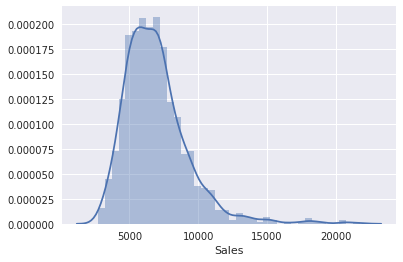

In [12]:
# Средние продажи в магазинах по дням, когда продажи были > 0
sns.distplot(df_train_sales.groupby(['Store']).mean()['Sales'])

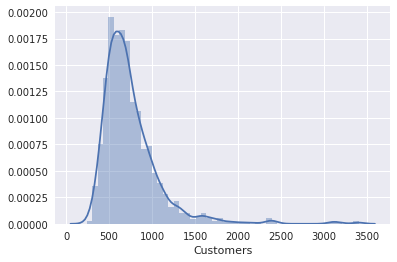

In [13]:
# Среднее количество покупателей в магазинах
sns.distplot(df_train_sales.groupby(['Store']).mean()['Customers'])

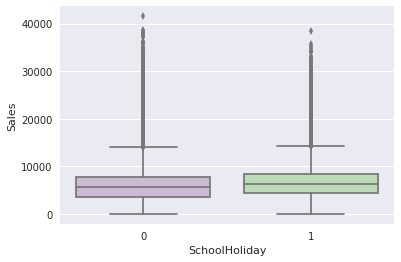

In [14]:
# Влияет ли работа школ на продажи?
sns.boxplot(x=df_train['SchoolHoliday'], y=df_train['Sales'], palette="PRGn")
# Пожалуй, некоторое смещение наблюдается, но едва уловимое

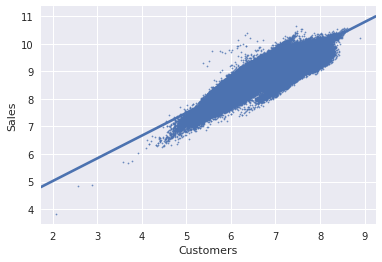

In [15]:
# Как связано количество продаж и количество покупателей?
df_train_sales_customers = df_train_sales[df_train_sales['Customers'] != 0]
x = np.log(df_train_sales_customers['Customers'])
y = np.log(df_train_sales_customers['Sales'])
sns.regplot(x, y, scatter_kws={'s':3}, fit_reg=True)

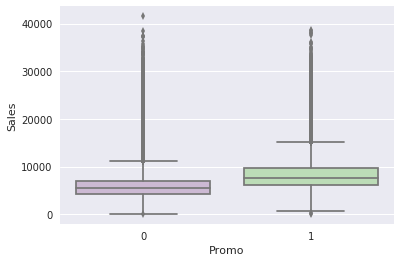

In [16]:
# Зависимость продаж от промо-акции
sns.boxplot(x=df_train_sales['Promo'], y=df_train_sales['Sales'], palette="PRGn")
# Здесь зависимость достаточно заметна

In [17]:
# Среднее количество продаж на одного покупателя
df_train_no_promo = df_train_sales[df_train_sales['Promo'] == 0]
df_train_promo = df_train_sales[df_train_sales['Promo'] == 1]
print(np.mean(df_train_no_promo['Sales']/df_train_no_promo['Customers']))
print(np.mean(df_train_promo['Sales']/df_train_promo['Customers']))

8.941127696725117
10.178960909582786


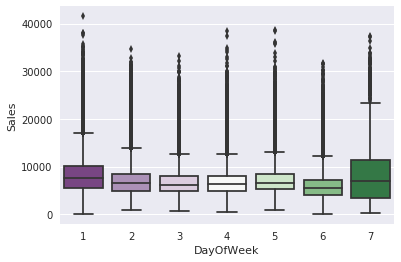

In [18]:
# Продажи в зависимости от дня недели
sns.boxplot(x=df_train_sales['DayOfWeek'], y=df_train_sales['Sales'], palette="PRGn")
# В пятницу, воскресенье и понедельник продажи повышаются

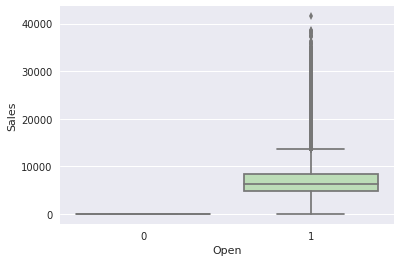

In [19]:
# Продажи в зависимости от того, открыт ли магазин
sns.boxplot(x=df_train['Open'], y=df_train['Sales'], palette="PRGn")

In [20]:
train_stores = np.unique(df_train['Store'])
test_stores = np.unique(df_test['Store'])
stores_difference = np.setdiff1d(train_stores, test_stores)
print(len(train_stores))
print(len(test_stores))
print(len(stores_difference))

1115
856
259


Мы видим, что в тестовом наборе меньше магазинов, чем в тренировочном

In [21]:
# Рассмотрим даты в тренировочном и тестовом наборе
train_date_min = df_train['Date'].min()
train_date_max = df_train['Date'].max()
test_date_min = df_test['Date'].min()
test_date_max = df_test['Date'].max()
print(train_date_min, train_date_max)
print(test_date_min, test_date_max)

2013-01-01 00:00:00 2015-07-31 00:00:00
2015-08-01 00:00:00 2015-09-17 00:00:00


Однако даты в тестовом наборе находятся после дат в тренировочном. Поэтому мы можем использовать "исторические" данные, чтобы обучить модель и пытаться делать предсказание на будущее.

In [22]:
df_train_store = pd.merge(df_train, df_store, on='Store')
df_train_store = df_train_store.sort_values(['Date'])
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,-1.0,-1.0,1
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,2640.0,-1.0,-1.0,0
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.0,11.0,2012.0,1
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,23130.0,-1.0,-1.0,0


In [23]:
df_test_store = pd.merge(df_test, df_store, on='Store')
df_test_store = df_test_store.sort_values(['Date'])
df_test_store.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2
20543,40660,553,6,2015-08-01,1.0,0,0,0,c,a,3040.0,9.0,2002.0,1
14543,40535,394,6,2015-08-01,1.0,0,0,1,d,a,10850.0,-1.0,-1.0,0
14495,40534,393,6,2015-08-01,1.0,0,0,0,d,c,4820.0,3.0,2008.0,0
14447,40533,392,6,2015-08-01,1.0,0,0,0,a,a,2120.0,-1.0,-1.0,0
14399,40532,391,6,2015-08-01,1.0,0,0,0,a,a,460.0,11.0,2014.0,1


### 2. Построить простую модель и реализовать подбор параметров и кросс-валидацию для данных с учётом наличия времени в данных

Так как у нас множество временных рядов, а не один, то будем использовать модели на признаках. Для начала преобразуем множество df_train_store.

### Baseline
В качестве простейшего наивного предсказания возьмём продажи за предыдущий день

In [24]:
# Посчитаем продажи за предыдущий день и разницу в продажах 
# за предыдущий день и день перед ним
df_train_store_1 = df_train_store.copy()
df_train_store_1['LastDaySales'] = df_train_store_1.groupby(['Store'])['Sales'].shift()
df_train_store_1['LastDayDiff'] = df_train_store_1.groupby(['Store'])['LastDaySales'].diff()
df_train_store_1 = df_train_store_1.dropna()
df_train_store_1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,LastDaySales,LastDayDiff
413475,453,4,2013-01-03,6109,740,1,0,0,1,a,c,75860.0,-1.0,-1.0,0,8265.0,8265.0
276245,304,4,2013-01-03,5457,893,1,0,0,1,a,a,1950.0,7.0,2015.0,0,7108.0,7108.0
145197,160,4,2013-01-03,5068,523,1,0,0,1,d,c,17110.0,11.0,2005.0,0,5726.0,5726.0
515483,565,4,2013-01-03,5262,645,1,0,0,1,a,c,160.0,7.0,2007.0,0,5856.0,5856.0
648253,712,4,2013-01-03,6250,566,1,0,0,1,a,a,4870.0,9.0,2007.0,1,6377.0,6377.0


In [25]:
# Средняя ошибка по всем магазинам в определённый день
mean_error = []

for day in pd.date_range(train_date_min + pd.DateOffset(2), train_date_max):
    val = df_train_store_1[df_train_store_1['Date'] == day]
    predict = val['LastDaySales'].values
    error = rmsle(val['Sales'].values, predict)
    mean_error.append(error)
    
print(min(mean_error))
print(max(mean_error))
print('Mean Error = %.5f' % np.mean(mean_error))

0.07307533699923388
9.421191308469721
Mean Error = 3.00912


В задании нам необходимо предсказать продажи на 47 дней вперёд относительно последней даты, определённой в тренировочных данных. 

In [26]:
test_date_max - test_date_min

Timedelta('47 days 00:00:00')

In [27]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [28]:
def get_num_cols(df):
    return df[['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'SchoolHoliday', \
               'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2']]

def get_num_cols_2(df):
    return df[['Store', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', \
               'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2']]

def get_state_holiday(df):
    return df['StateHoliday']

def get_store_type(df):
    return df['StoreType']

def get_assortment(df):
    return df['Assortment']

def get_sales_diff_cols_1(df):
    return df[['LastDaySales', 'LastDayDiff']]

def get_sales_diff_cols_1_month(df):
    return df[['LastMonthSales', 'LastMonthDiff']]

def get_sales_diff_cols_2(df):
    return df[['LastDaySales', 'LastDayDiff', 
               'LastDaySales-1', 'LastDayDiff-1']]

def get_sales_diff_cols_8(df):
    return df[['LastDaySales', 'LastDayDiff', 
               'LastDaySales-1', 'LastDayDiff-1', \
               'LastDaySales-2', 'LastDayDiff-2', \
               'LastDaySales-3', 'LastDayDiff-3', \
               'LastDaySales-4', 'LastDayDiff-4', \
               'LastDaySales-5', 'LastDayDiff-5', \
               'LastDaySales-6', 'LastDayDiff-6', \
               'LastDaySales-7', 'LastDayDiff-7']]

vec_0 = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols_2, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_store_type, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_assortment, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False))
])

vec_1 = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols_2, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_store_type, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_assortment, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sales_diff_cols_1, validate=False))
])

vec_1_month = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols_2, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_store_type, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_assortment, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sales_diff_cols_1_month, validate=False))
])

vec_2 = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols_2, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_store_type, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_assortment, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sales_diff_cols_2, validate=False))
])

vec_8 = make_union(*[
    make_pipeline(FunctionTransformer(get_num_cols_2, validate=False), Imputer(strategy='mean')),
    make_pipeline(FunctionTransformer(get_store_type, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_assortment, validate=False), LabelEncoderPipelineFriendly(), OneHotEncoder(sparse=False)),
    make_pipeline(FunctionTransformer(get_sales_diff_cols_8, validate=False))
])

In [29]:
%%time
mean_error = []
for day in pd.date_range(train_date_max - pd.DateOffset(6), train_date_max):
    train = df_train_store_1[df_train_store_1['Date'] < day]
    val = df_train_store_1[df_train_store_1['Date'] == day]
    
    x_train = vec_1.fit_transform(train)
    x_test = vec_1.fit_transform(val)
    y_train = train['Sales'].values
    y_test = val['Sales'].values
    
    model_lr = LinearRegression()
    model_lr.fit(x_train, np.log1p(y_train))
    
    predict = np.expm1(model_lr.predict(x_test))
    
    error = rmsle(y_test, predict)
    print('Day %s - Error %.5f' % (str(day), error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Day 2015-07-25 00:00:00 - Error 0.38494
Day 2015-07-26 00:00:00 - Error 0.20507
Day 2015-07-27 00:00:00 - Error 0.37698
Day 2015-07-28 00:00:00 - Error 0.24369
Day 2015-07-29 00:00:00 - Error 0.26674
Day 2015-07-30 00:00:00 - Error 0.17669
Day 2015-07-31 00:00:00 - Error 0.24637
Mean Error = 0.27150
CPU times: user 32.2 s, sys: 4.79 s, total: 37 s
Wall time: 27.1 s


#### Линейная регрессия без временного лага

In [30]:
%%time
mean_error = []
for day in pd.date_range(train_date_max - pd.DateOffset(6), train_date_max):
    train = df_train_store[df_train_store['Date'] < day]
    val = df_train_store[df_train_store['Date'] == day]
    
    x_train = vec_0.fit_transform(train)
    x_test = vec_0.fit_transform(val)
    y_train = train['Sales'].values
    y_test = val['Sales'].values
    
    model_lr = LinearRegression()
    model_lr.fit(x_train, np.log1p(y_train))
    
    predict = np.expm1(model_lr.predict(x_test))
    
    error = rmsle(y_test, predict)
    print('Day %s - Error %.5f' % (str(day), error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Day 2015-07-25 00:00:00 - Error 0.48125
Day 2015-07-26 00:00:00 - Error 0.11795
Day 2015-07-27 00:00:00 - Error 0.34772
Day 2015-07-28 00:00:00 - Error 0.31516
Day 2015-07-29 00:00:00 - Error 0.31950
Day 2015-07-30 00:00:00 - Error 0.31623
Day 2015-07-31 00:00:00 - Error 0.34839
Mean Error = 0.32088
CPU times: user 29.2 s, sys: 4.4 s, total: 33.6 s
Wall time: 25.6 s


In [31]:
x_train = vec_0.fit_transform(df_train_store)
y_train = df_train_store['Sales'].values

model_lr = LinearRegression()
model_lr.fit(x_train, np.log1p(y_train))

x_test = vec_0.fit_transform(df_test_store)
predict = np.expm1(model_lr.predict(x_test))

In [32]:
df_test_store['Sales'] = predict
df_test_store.to_csv('submission.csv', columns = ['Id', 'Sales'], index=False)

Оценка этой модели на Kaggle - 0.37592

#### Случайный лес без временного лага

In [33]:
%%time
mean_error = []
for day in pd.date_range(train_date_max - pd.DateOffset(6), train_date_max):
    train = df_train_store[df_train_store['Date'] < day]
    val = df_train_store[df_train_store['Date'] == day]
    
    x_train = vec_0.fit_transform(train)
    x_test = vec_0.fit_transform(val)
    y_train = train['Sales'].values
    y_test = val['Sales'].values
    
    model_forest = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42)
    model_forest.fit(x_train, np.log1p(y_train))
    
    predict = np.expm1(model_forest.predict(x_test))
    
    error = rmsle(y_test, predict)
    print('Day %s - Error %.5f' % (str(day), error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Day 2015-07-25 00:00:00 - Error 0.19539
Day 2015-07-26 00:00:00 - Error 0.06496
Day 2015-07-27 00:00:00 - Error 0.13211
Day 2015-07-28 00:00:00 - Error 0.12938
Day 2015-07-29 00:00:00 - Error 0.13290
Day 2015-07-30 00:00:00 - Error 0.13258
Day 2015-07-31 00:00:00 - Error 0.24556
Mean Error = 0.14755
CPU times: user 32min 46s, sys: 2.48 s, total: 32min 48s
Wall time: 16min 37s


In [34]:
x_train = vec_0.fit_transform(df_train_store)
y_train = df_train_store['Sales'].values

model_forest = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42)
model_forest.fit(x_train, np.log1p(y_train))

x_test = vec_0.fit_transform(df_test_store)
predict = np.expm1(model_forest.predict(x_test))

In [35]:
df_test_store['Sales'] = predict
df_test_store.to_csv('submission.csv', columns = ['Id', 'Sales'], index=False)

Оценка этой модели на Kaggle - 0.14308

#### Случайный лес с временным лагом в один месяц

In [36]:
# Добавим в тестовые данные столбцы с годом и месяцем и средними продажами за месяц
df_train_store_m = df_train_store.copy()
df_train_store_m['YearMonth'] = df_train_store_m['Date'].map(lambda x: 1000*x.year + x.month)
df_train_store_m.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,YearMonth
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,-1.0,-1.0,1,2013001
679363,746,2,2013-01-01,0,0,0,0,a,1,d,c,4330.0,2.0,2011.0,1,2013001
155193,171,2,2013-01-01,0,0,0,0,a,1,a,a,2640.0,-1.0,-1.0,0,2013001
632403,694,2,2013-01-01,0,0,0,0,a,1,a,c,460.0,11.0,2012.0,1,2013001
361623,396,2,2013-01-01,0,0,0,0,a,1,a,c,23130.0,-1.0,-1.0,0,2013001


In [37]:
# Сгруппированные по магазинам и месяцам и усреднённые продажи
df_month_mean_sales = df_train_store_m.groupby(['Store', 'YearMonth'])['Sales'].mean().reset_index()
df_month_mean_sales = df_month_mean_sales.rename(columns={'Sales': 'SalesMonth'})
df_month_mean_sales.head()

,Store,YearMonth,SalesMonth
0,1,2013001,4142.935484
1,1,2013002,4473.964286
2,1,2013003,4682.870968
3,1,2013004,3933.633333
4,1,2013005,3813.709677


In [38]:
df_train_store_m = pd.merge(df_train_store_m, df_month_mean_sales, on=['Store', 'YearMonth'])
df_train_store_m.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,YearMonth,SalesMonth
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871
1,1115,3,2013-01-02,3697,305,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871
2,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871
3,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871
4,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871


In [39]:
df_train_store_lag_m = df_train_store_m.copy()
df_train_store_lag_m['LastMonthSales'] = df_train_store_lag_m.groupby(['Store'])['SalesMonth'].shift()
df_train_store_lag_m['LastMonthDiff'] = df_train_store_lag_m.groupby(['Store'])['LastMonthSales'].diff()
df_train_store_lag_m = df_train_store_lag_m.dropna()
df_train_store_lag_m.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,YearMonth,SalesMonth,LastMonthSales,LastMonthDiff
2,1115,4,2013-01-03,4297,300,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871,3757.483871,0.0
3,1115,5,2013-01-04,4540,326,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871,3757.483871,0.0
4,1115,6,2013-01-05,4771,339,1,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871,3757.483871,0.0
5,1115,7,2013-01-06,0,0,0,0,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871,3757.483871,0.0
6,1115,1,2013-01-07,6905,471,1,1,0,1,d,c,5350.0,-1.0,-1.0,1,2013001,3757.483871,3757.483871,0.0


In [40]:
%%time
mean_error = []   
for day in pd.date_range(train_date_max - pd.DateOffset(months=5), train_date_max, freq='MS'):
    train = df_train_store_lag_m[df_train_store_lag_m['Date'] < day]
    val = df_train_store_lag_m[df_train_store_lag_m['Date'] == day]
    
    x_train = vec_1_month.fit_transform(train)
    x_test = vec_1_month.fit_transform(val)
    y_train = train['Sales'].values
    y_test = val['Sales'].values
    
    model_forest = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42)
    model_forest.fit(x_train, np.log1p(y_train))
    
    predict = np.expm1(model_forest.predict(x_test))
    
    error = rmsle(y_test, predict)
    print('Day %s - Error %.5f' % (str(day), error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Day 2015-03-01 00:00:00 - Error 0.01639
Day 2015-04-01 00:00:00 - Error 0.28038
Day 2015-05-01 00:00:00 - Error 0.06553
Day 2015-06-01 00:00:00 - Error 0.13544
Day 2015-07-01 00:00:00 - Error 0.14818
Mean Error = 0.12919
CPU times: user 31min 38s, sys: 5.36 s, total: 31min 43s
Wall time: 16min 2s


#### Случайный лес с временным лагом в один день

Для использования этой модели необходимо для тестовых данных заполнить столбцы LastDaySales и LastDayDiff, которые сами зависят от значения, которое необходимо предсказать. Это своеобразная "алгебраическая петля", и чтобы её разорвать, нужно, похоже, использовать некие итерации. Мы же поступим проще, и возьмём эти значения, используя известные предыдущие значения и скользящее среднее.

In [41]:
df_train_test = df_train_store_1.append(df_test_store)

In [42]:
df_train_test_2 = df_train_test.copy()

In [43]:
n_mean = 14  # кол-во предыдущих значений для усреднения

change_dict_LastDaySales = {}

for group_id, series in df_train_test_2.groupby(['Store'])['LastDaySales']:
    lst = []
    for index, value in series.iteritems():
        if np.isnan(value):
            value = np.mean(lst)
                
        if len(lst) == n_mean:
            lst.pop(0)
        lst.append(value)
            
        change_dict_LastDaySales[index] = value 

In [44]:
change_dict_LastDayDiff = {}

for group_id, series in df_train_test_2.groupby(['Store'])['LastDayDiff']:
    lst = []
    for index, value in series.iteritems():
        if np.isnan(value):
            value = np.mean(lst)

        if len(lst) == n_mean:
            lst.pop(0)
        lst.append(value)

        change_dict_LastDayDiff[index] = value

In [45]:
# заменяем отсутствующие значения для тестовых данных на скользящие средние
df_train_test_2['LastDaySales'] = pd.Series(change_dict_LastDaySales)
df_train_test_2['LastDayDiff'] = pd.Series(change_dict_LastDayDiff)

In [46]:
# Заменяем пропущенные значения в столбце Open в тестовых данных
df_train_test_2 = df_train_test_2.fillna(value={'Open': 0})

In [47]:
# обучаем случайный лес на тренировочных данных
train = df_train_test_2[df_train_test_2['Date'] <= train_date_max]
    
x_train = vec_1.fit_transform(train)
y_train = train['Sales'].values
    
model_forest = RandomForestRegressor(n_estimators=100, n_jobs=2, random_state=42)
model_forest.fit(x_train, np.log1p(y_train))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
test = df_train_test_2[df_train_test_2['Date'] > train_date_max]
x_test = vec_1.fit_transform(test)
predict = np.expm1(model_forest.predict(x_test))

In [49]:
df_predict = df_train_test_2[df_train_test_2['Date'] > train_date_max]

In [50]:
df_predict['Sales'] = predict

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
df_predict['Id'] = df_predict['Id'].astype(int)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
df_predict.to_csv('submission.csv', columns = ['Id', 'Sales'], index=False)

Оценка этой модели на Kaggle - 0.22655, т.е. ухудшилась по отношению к простому случайному лесу

#### Градиентный бустинг

In [53]:
%%time
mean_error = []
for day in pd.date_range(train_date_max - pd.DateOffset(6), train_date_max):
    train = df_train_store[df_train_store['Date'] < day]
    val = df_train_store[df_train_store['Date'] == day]
    
    x_train = vec_0.fit_transform(train)
    x_test = vec_0.fit_transform(val)
    y_train = train['Sales'].values
    y_test = val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(x_train, np.log1p(y_train))
    
    predict = np.expm1(mdl.predict(x_test))
    
    error = rmsle(y_test, predict)
    print('Day %s - Error %.5f' % (str(day), error))
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Day 2015-07-25 00:00:00 - Error 0.34142
Day 2015-07-26 00:00:00 - Error 0.07141
Day 2015-07-27 00:00:00 - Error 0.23326
Day 2015-07-28 00:00:00 - Error 0.21522
Day 2015-07-29 00:00:00 - Error 0.21317
Day 2015-07-30 00:00:00 - Error 0.21813
Day 2015-07-31 00:00:00 - Error 0.27968
Mean Error = 0.22461
CPU times: user 40min 12s, sys: 19.3 s, total: 40min 31s
Wall time: 6min 2s


Простой случайный лес в нашем случае оказался лучшей моделью

Ссылка на Kaggle:

https://www.kaggle.com/c/rossmann-store-sales/submissions?sortBy=date&group=all&page=1

Ник: Nikita Chernetsov

Лучшая оценка: 0.14308 (случайный лес без временного лага)